202599


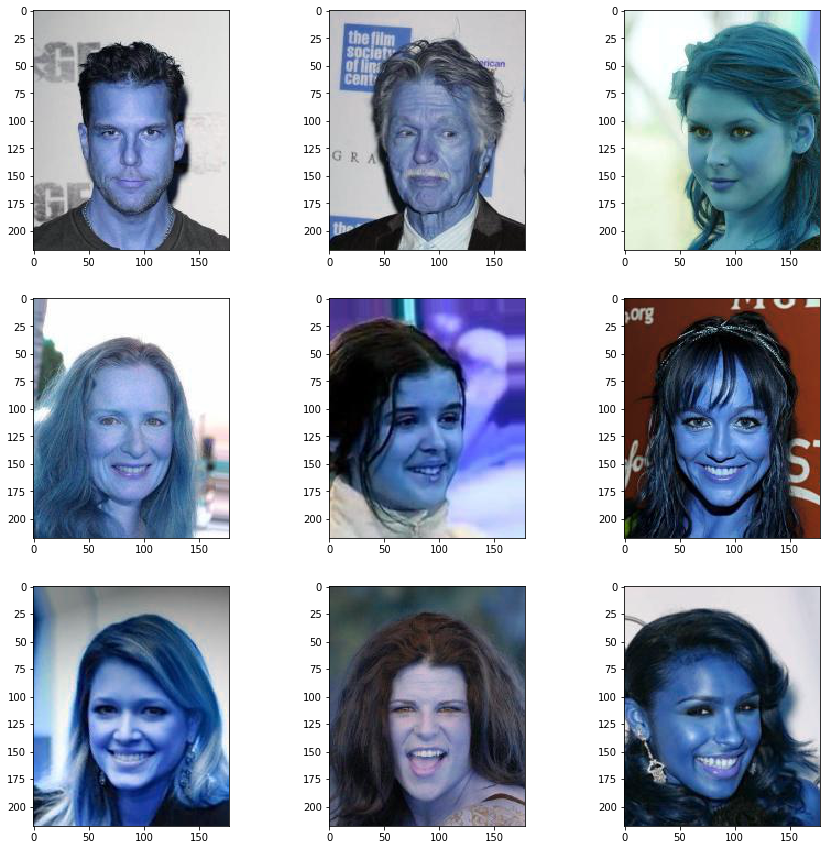

In [1]:
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm import tqdm

from tensorflow.contrib.data import Dataset, Iterator

import random
CELEBA_DATE_DIR = 'img_align_celeba'
train_images = []
for image_filename in os.listdir(CELEBA_DATE_DIR):
    if image_filename.endswith('.jpg'):
        train_images.append(os.path.join(CELEBA_DATE_DIR, image_filename))

random.shuffle(train_images) 
 
batch_size = 64
num_batch = len(train_images) // batch_size
IMAGE_SIZE = 64
IMAGE_CHANNEL = 3

print(len(train_images))

def get_next_batch(pointer):
    image_batch = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, 3))
    images = train_images[pointer*batch_size:(pointer+1)*batch_size]
    i=0
    for img in images:
        image = cv2.imread(img)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = image.astype('float32') / 127.5 - 1
        image_batch[i,:,:,:] = image
        i+=1
        
    return image_batch


fig = plt.figure(figsize=(15,15))
for i in range(9):
    img = train_images[i]
    ax = fig.add_subplot(3,3,i+1)
    image = cv2.imread(img)
        
    ax.imshow(image)


In [2]:

def generator(noise, phase=True):
    with tf.variable_scope("Generator"):
        out1 = tf.contrib.layers.fully_connected(noise, 2*IMAGE_SIZE*IMAGE_SIZE,activation_fn=None, scope ="G_linear" )
        out1 = tf.reshape(out1, [-1, 4, 4, IMAGE_SIZE*8])
        out1 = tf.nn.relu(out1, name =  "G_relu1")
        
        out2 = tf.contrib.layers.conv2d_transpose(out1, IMAGE_SIZE*4, 5,stride=2, padding='SAME', scope = 'G_conv2')
        out2 = tf.contrib.layers.batch_norm(out2, center=True, scale=True, 
                                          is_training=phase, scope="G_BN2")
        out2 = tf.nn.relu(out2, name="G_relu2")    
        
        
        out3 = tf.contrib.layers.conv2d_transpose(out2, IMAGE_SIZE*2, 5,stride=2, padding='SAME', scope = 'G_conv3')
        out3 = tf.contrib.layers.batch_norm(out3, center=True, scale=True, 
                                      is_training=phase, scope="G_BN3")
        out3 = tf.nn.relu(out3, name="G_relu3")    
        
        out4 = tf.contrib.layers.conv2d_transpose(out3, IMAGE_SIZE, 5,stride=2, padding='SAME', scope = 'G_conv4')
        out4 = tf.contrib.layers.batch_norm(out4, center=True, scale=True, 
                                          is_training=phase, scope="G_BN4")
        out4 = tf.nn.relu(out4, name="G_relu4")  
        
        out5 = tf.contrib.layers.conv2d_transpose(out4, 3, 5,stride=2, padding='SAME', scope = 'G_conv5')
        out5 = tf.contrib.layers.batch_norm(out5, center=True, scale=True, 
                                          is_training=phase, scope="G_BN5")
        out5 = tf.nn.tanh(out5, name="G_relu5")    
        
    return out5



In [3]:


def discriminator(input_images, reuse=False, phase = True):   

    if reuse:
        tf.get_variable_scope().reuse_variables()
    
    out1 = tf.contrib.layers.conv2d(input_images,IMAGE_SIZE, 5,stride=2, padding='SAME',  scope="D_conv1" )
    out1 = tf.nn.leaky_relu(out1, name="D_LK1")
    
    out2 =  tf.contrib.layers.conv2d(out1, IMAGE_SIZE*2, 5,stride=2, padding='SAME',  scope="D_conv2" )
    out2 = tf.contrib.layers.batch_norm(out2, center=True, scale=True, 
                                          is_training=phase, scope="D_BN2")
    out2 = tf.nn.leaky_relu(out2, name="D_LK2")    

    out3 =   tf.contrib.layers.conv2d(out2,IMAGE_SIZE*4, 5,stride=2, padding='SAME',  scope="D_conv3" )
    out3 = tf.contrib.layers.batch_norm(out3, center=True, scale=True, 
                                          is_training=phase, scope="D_BN3")
    out3 = tf.nn.leaky_relu(out3, name="D_LK3")   
    
    out4 =  tf.contrib.layers.conv2d(out3,IMAGE_SIZE*8, 5,stride=2, padding='SAME',  scope="D_conv4" )
    out4 = tf.contrib.layers.batch_norm(out4, center=True, scale=True, 
                                          is_training=phase, scope="D_BN4")
    out4 = tf.nn.leaky_relu(out4, name="D_LK4")   

    out5 = tf.reshape(out4, [-1, 8192])
    out5 = tf.contrib.layers.fully_connected(inputs=out5,num_outputs=1,activation_fn=None, scope='D_linear')
    
    out6 =tf.nn.sigmoid(out5, name="D_sigmoid")


    return out6,out5


In [4]:

z_dim = 100

z = tf.placeholder( tf.float32, [None,100], name='noise')
is_training = tf.placeholder(tf.bool, name='is_training')
Images = tf.placeholder(
            tf.float32, [None,IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNEL], name='real_images')



G = generator(z, phase=is_training)

with tf.variable_scope("Discriminator" ) as scope:
    D, D_logits = discriminator(Images, reuse=False, phase = is_training)
    scope.reuse_variables()
    D_,D_logits_ = discriminator(G, reuse =True, phase = is_training)



d_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logits, labels = tf.ones_like(D)))

d_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logits_,labels = tf.zeros_like(D_)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits = D_logits_,labels = tf.ones_like(D_)))

t_vars = tf.trainable_variables()

d_vars = [var for var in t_vars if 'Discriminator' in var.name]
g_vars = [var for var in t_vars if 'Generator' in var.name]


learning_rate = 0.001
lr_decay = 0.9
beta1 = 0.9

d_optim = tf.train.AdamOptimizer(learning_rate) \
                    .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(learning_rate) \
                    .minimize(g_loss, var_list=g_vars)

In [5]:
d_vars

[<tf.Variable 'Discriminator/D_conv1/weights:0' shape=(5, 5, 3, 64) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv1/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv2/weights:0' shape=(5, 5, 64, 128) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv2/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_BN2/gamma:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_BN2/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv3/weights:0' shape=(5, 5, 128, 256) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv3/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_BN3/gamma:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_BN3/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv4/weights:0' shape=(5, 5, 256, 512) dtype=float32_ref>,
 <tf.Variable 'Discriminator/D_conv4/biases:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable '

In [6]:
g_vars

[<tf.Variable 'Generator/G_linear/weights:0' shape=(100, 8192) dtype=float32_ref>,
 <tf.Variable 'Generator/G_linear/biases:0' shape=(8192,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_conv2/weights:0' shape=(5, 5, 256, 512) dtype=float32_ref>,
 <tf.Variable 'Generator/G_conv2/biases:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_BN2/gamma:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_BN2/beta:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_conv3/weights:0' shape=(5, 5, 128, 256) dtype=float32_ref>,
 <tf.Variable 'Generator/G_conv3/biases:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_BN3/gamma:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_BN3/beta:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_conv4/weights:0' shape=(5, 5, 64, 128) dtype=float32_ref>,
 <tf.Variable 'Generator/G_conv4/biases:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Generator/G_BN4/gamma:0' shape=(64,) dtype=floa

start
INFO:tensorflow:Restoring parameters from ./gan_model.ckpt
start  0
0 0.0113365 11.7276 14.371906757354736
Model saved in file: ./gan_model.ckpt
1 0.0122917 11.2364 19.883464813232422
2 0.00259741 9.72021 11.93776249885559
3 0.000348686 8.76595 11.817538261413574
4 0.00127563 7.93091 11.763849020004272
5 0.0023149 6.42384 11.166491746902466
6 0.0058449 5.91356 11.496929168701172
7 0.00555611 6.16129 11.186076879501343
8 0.00439589 6.68619 11.282084703445435
9 0.0316812 6.77629 10.970335245132446
10 0.00620439 6.49003 13.033126831054688
11 0.0100039 7.98081 10.903395891189575
12 0.00129204 9.25778 11.767826795578003
13 0.00718177 9.88388 11.81921911239624
14 0.00227841 9.49649 10.911357402801514
15 0.0214576 8.91758 12.748808145523071
16 0.0269544 7.98934 11.041643142700195
17 0.0022312 7.056 10.702878952026367
18 0.0021919 6.48635 11.325326204299927
19 0.0146458 6.34577 11.349938869476318
20 0.00790508 5.54031 10.905339479446411
21 0.028332 8.69855 11.073333978652954
22 0.0014355

199 0.0114252 6.02998 9.847647666931152
200 0.0100899 6.92502 9.88771653175354
Model saved in file: ./gan_model.ckpt
201 0.00728637 7.84188 18.229236841201782
202 0.00213484 8.27868 10.24885082244873
203 0.00118393 8.37548 10.382777690887451
204 0.00127976 7.8014 10.248125076293945
205 0.00543388 7.32637 10.758435249328613
206 0.00373081 6.93495 10.136325359344482
207 0.00440227 6.61917 10.141849756240845
208 0.00541461 7.03559 9.822453022003174
209 0.00388953 7.65447 9.938393354415894
210 0.00161397 8.05309 9.949909687042236
211 0.00233966 7.91322 9.668882846832275
212 0.00298984 7.60634 9.842085123062134
213 0.017334 7.12855 10.152811050415039
214 0.0042831 6.59854 9.7660551071167
215 0.0112714 6.21865 9.898988246917725
216 0.0166447 6.3124 10.138412237167358
217 0.00976758 6.90224 9.934051513671875
218 0.00561597 7.35298 9.840294122695923
219 0.00715 8.06396 9.890712022781372
220 0.00770642 8.36023 9.715023279190063
221 0.00502356 8.16932 10.01185655593872
222 0.00253566 7.81931 9.9

405 0.705731 2.81876 14.558634042739868
406 0.597775 2.4032 14.35555362701416
407 0.650011 3.78587 9.951497077941895
408 0.59692 4.8605 10.84525203704834
409 0.371935 5.33518 10.450846910476685
410 0.41309 3.98714 9.704658031463623
411 0.393824 3.20395 9.910536289215088
412 0.510369 5.19561 9.893114805221558
413 0.340289 7.57174 9.814852714538574
414 0.619802 7.55801 9.434603929519653
415 0.775965 5.48539 10.04787302017212
416 0.401816 4.14783 9.781956672668457
417 0.345756 4.48015 9.7322838306427
418 0.135279 5.54837 9.805521011352539
419 0.462195 6.15783 9.862821817398071
420 0.161081 7.42293 9.67860460281372
421 0.156505 7.35786 9.97623610496521
422 0.0880266 5.85666 9.751440525054932
423 0.546382 5.31417 9.572115898132324
424 0.99506 7.68693 9.776377201080322
425 0.718466 7.10225 9.84479308128357
426 2.11649 1.80372 9.836362361907959
427 1.94055 10.7979 9.714770793914795
428 1.35836 9.50165 9.488496541976929
429 0.666392 3.88871 9.708502292633057
430 2.00827 9.14672 9.7149267196655

617 0.195931 4.1288 9.602779388427734
618 1.01812 6.69697 9.64441728591919
619 0.569863 9.7508 9.591900825500488
620 0.589753 9.48554 9.53285551071167
621 0.616138 3.30315 9.325761079788208
622 1.10784 5.53004 10.26761794090271
623 0.332559 8.10189 9.578946590423584
624 0.475652 6.31111 9.562249183654785
625 0.563604 4.05947 9.590571165084839
626 0.439536 3.59859 9.463008165359497
627 0.736161 5.25418 9.940685272216797
628 0.472737 7.03625 9.695772886276245
629 1.83714 3.97142 9.453968048095703
630 0.800277 2.19291 9.593463897705078
631 1.00638 5.63574 11.380216598510742
632 0.422395 7.4237 9.463007688522339
633 0.569485 7.60569 9.4295072555542
634 1.64202 3.07246 9.493508100509644
635 1.30107 4.87382 9.79066252708435
636 0.234727 6.39845 9.614282846450806
637 0.0714717 6.84392 9.453368902206421
638 1.13763 4.9746 9.514501571655273
639 0.319774 4.04507 9.388692140579224
640 0.408109 4.7135 9.388334512710571
641 0.178578 5.15093 9.942283868789673
642 0.415028 5.26241 9.34824538230896
64

829 0.672894 4.11223 10.117760181427002
830 0.323551 5.57648 9.635209798812866
831 0.158053 6.97894 9.831279516220093
832 0.473056 5.84762 9.82973337173462
833 0.489267 2.92442 9.719904899597168
834 0.626919 2.397 9.628865718841553
835 0.974535 4.88141 9.763412714004517
836 0.343026 7.51685 10.41351056098938
837 0.510236 7.84528 9.653660535812378
838 1.97928 3.34219 9.645392656326294
839 0.768739 2.3192 12.798398971557617
840 1.44784 3.50921 14.406395435333252
841 0.586339 6.18502 15.701340913772583
842 0.642872 6.96236 11.186276912689209
843 1.2602 6.3286 10.408671140670776
844 0.459053 4.97635 9.764795780181885
845 0.413362 3.56907 9.704156160354614
846 0.801225 4.61432 10.139454364776611
847 0.465291 6.39421 9.70014500617981
848 0.356175 8.36606 9.514609575271606
849 0.332241 7.87945 9.939543962478638
850 0.391784 5.39834 10.373634099960327
851 0.539522 4.04213 10.04283881187439
852 0.652963 4.61454 9.851151704788208
853 0.288868 5.7879 10.939998626708984
854 0.554215 4.87201 10.006

1039 0.250394 4.34753 9.400632619857788
1040 0.475695 4.27472 9.586751699447632
1041 0.528551 3.90758 9.342702388763428
1042 0.507076 3.84209 9.44315218925476
1043 1.26265 2.30284 9.310470581054688
1044 1.38859 3.12346 9.314881801605225
1045 1.05002 4.49325 9.532901763916016
1046 0.356854 5.63444 9.59937310218811
1047 0.663515 5.38142 9.423966407775879
1048 0.391749 5.45058 9.4594144821167
1049 0.478591 3.58472 9.643146753311157
1050 0.431136 4.27093 12.170008659362793
1051 0.372363 5.06906 10.242879867553711
1052 0.28707 6.12929 9.286228895187378
1053 0.550717 4.50781 9.310927867889404
1054 0.631059 3.90972 9.142082214355469
1055 0.348989 3.72671 9.451256275177002
1056 0.76488 4.03896 9.225867748260498
1057 0.874368 4.37268 9.298908472061157
1058 0.702316 4.24074 9.665781259536743
1059 0.528263 4.04324 9.46683382987976
1060 0.833752 3.3249 9.417441844940186
1061 0.620706 4.2268 9.224757194519043
1062 0.324297 5.36232 9.074261665344238
1063 0.297334 5.30479 9.256453275680542
1064 0.532

1244 0.211825 4.6544 9.763141632080078
1245 0.141065 5.06538 9.739058494567871
1246 0.179218 5.56938 9.77950406074524
1247 0.247272 4.403 9.459192276000977
1248 0.589917 2.92278 9.780017852783203
1249 0.316885 2.82547 9.759187936782837
1250 0.409744 3.22094 9.49044942855835
1251 0.28878 3.82368 9.688035488128662
1252 0.862539 2.33097 9.480414152145386
1253 0.551794 2.77023 9.913745403289795
1254 0.80071 2.62649 9.66672420501709
1255 1.07327 2.50563 9.62424612045288
1256 0.465062 3.46033 9.597702980041504
1257 0.503395 3.60853 9.54002332687378
1258 0.556264 3.46289 9.711568832397461
1259 0.41434 3.96558 9.661574840545654
1260 0.315673 3.78453 9.669667720794678
1261 0.388649 3.5187 9.534969806671143
1262 0.483552 3.72415 9.418183088302612
1263 0.339729 4.34331 9.319973230361938
1264 0.269174 3.3818 9.529738664627075
1265 0.268586 3.2094 9.575445175170898
1266 0.44447 3.53102 9.658057928085327
1267 0.691156 3.50162 9.623182535171509
1268 0.644574 4.10621 9.530955791473389
1269 0.486587 3.

1447 0.805181 3.47703 10.441118240356445
1448 0.381834 5.18419 10.05958342552185
1449 0.228043 6.18625 10.406418085098267
1450 0.28913 4.99785 10.222670316696167
1451 0.853294 3.78287 10.171451091766357
1452 0.480047 3.86821 10.060125589370728
1453 0.644357 3.42652 10.213774681091309
1454 0.663656 3.8793 10.363799810409546
1455 0.793737 2.46949 10.035455703735352
1456 0.913936 4.021 10.62364411354065
1457 0.592486 4.49465 10.252899646759033
1458 0.713566 3.95756 10.438136577606201
1459 0.626727 3.75337 70.77376055717468
1460 0.584525 4.17645 18.936522006988525
1461 0.894397 3.17529 11.718299150466919
1462 0.391961 3.49135 10.685938596725464
1463 0.884358 3.26111 11.13271689414978
1464 0.706145 3.85123 33.85984921455383
1465 0.526895 4.32988 10.418867826461792
1466 0.713736 3.16222 10.27772068977356
1467 0.623946 3.5988 10.463638067245483
1468 0.369634 3.301 10.349912166595459
1469 0.443948 2.2211 10.244011402130127
1470 0.541622 4.19895 10.925387382507324
1471 0.281274 4.99913 10.65556

1648 0.836897 2.86928 9.934117317199707
1649 0.641934 4.1701 10.592385530471802
1650 0.480247 5.42982 10.027073621749878
1651 0.905267 4.10015 10.031707763671875
1652 0.778885 3.23287 9.927234172821045
1653 0.423447 2.49343 9.985445737838745
1654 0.676947 3.71772 10.048845052719116
1655 0.247945 4.8721 9.739865064620972
1656 0.16486 6.52533 10.816603183746338
1657 0.362542 6.45195 10.044676542282104
1658 0.274962 5.18525 9.83789610862732
1659 0.38144 3.60546 10.245468854904175
1660 0.384671 3.09939 9.795911312103271
1661 0.572524 3.3219 9.824400424957275
1662 0.633928 4.04492 11.467991590499878
1663 0.269333 5.69147 10.022361993789673
1664 0.601535 5.9012 11.157042980194092
1665 0.684462 4.65312 9.611573934555054
1666 0.363654 3.07674 9.679945707321167
1667 0.462618 3.35098 9.895057678222656
1668 0.370866 4.45096 9.899588584899902
1669 0.341046 5.12656 9.842531204223633
1670 0.286379 5.40735 10.004401922225952
1671 0.289186 5.27126 9.668907403945923
1672 0.652491 4.33649 9.830447196960

1851 0.463936 3.59029 9.788043737411499
1852 0.640944 3.89873 9.785229206085205
1853 0.461781 5.54802 9.83985161781311
1854 0.191132 6.96192 9.734281539916992
1855 0.282235 6.83094 10.088289260864258
1856 0.59057 4.86684 9.940690040588379
1857 0.267797 4.34052 9.830917835235596
1858 0.339869 3.94053 9.982360124588013
1859 0.691582 4.32247 9.92438268661499
1860 0.271991 5.8276 9.902653932571411
1861 0.227497 7.38898 9.694680213928223
1862 1.08656 4.93397 9.79232382774353
1863 0.446801 3.00956 9.509539604187012
1864 0.894312 2.81739 9.572504758834839
1865 0.832691 4.4304 9.88680100440979
1866 0.660036 5.00674 9.586865663528442
1867 1.06213 3.44317 9.709753513336182
1868 0.636542 2.80366 9.35408616065979
1869 0.627979 4.47519 9.850732803344727
1870 0.625065 4.75515 9.581528425216675
1871 0.651017 5.03514 9.485859394073486
1872 0.643915 4.06509 9.440662860870361
1873 0.45841 3.58557 9.554857969284058
1874 0.515612 3.1164 9.542245626449585
1875 0.51679 3.40223 9.68348479270935
1876 0.681206

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Model saved in file: ./gan_model.ckpt


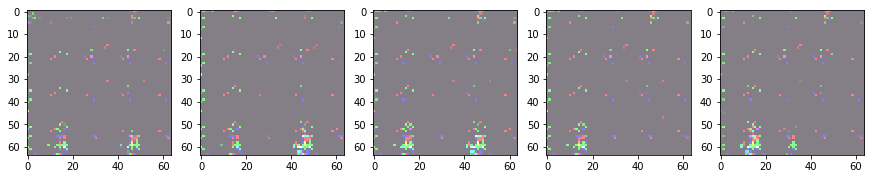

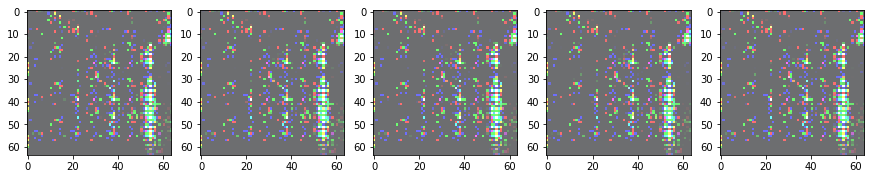

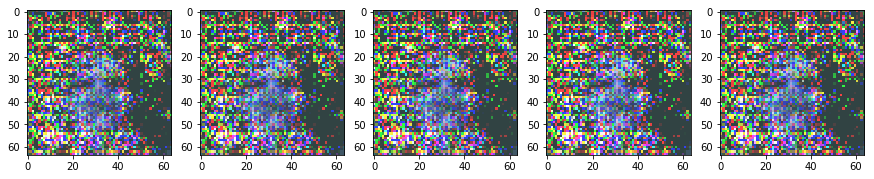

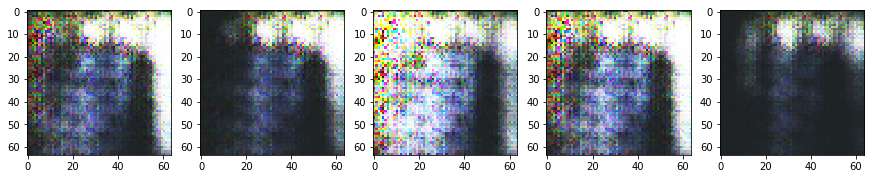

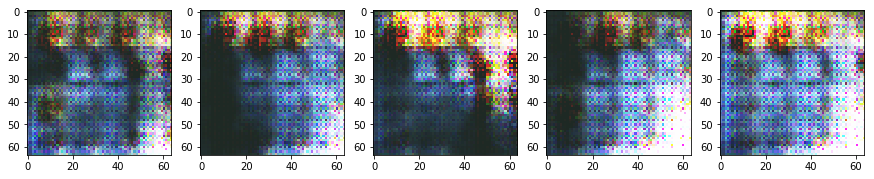

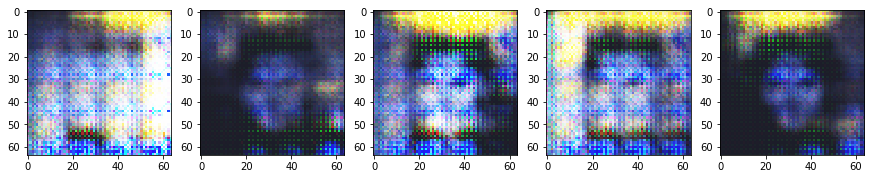

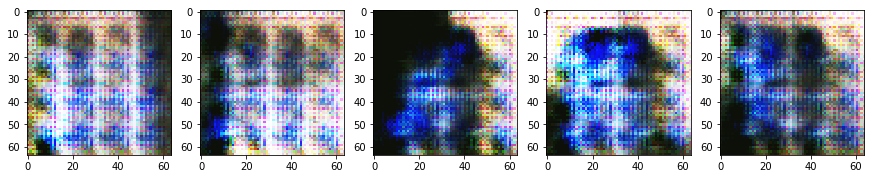

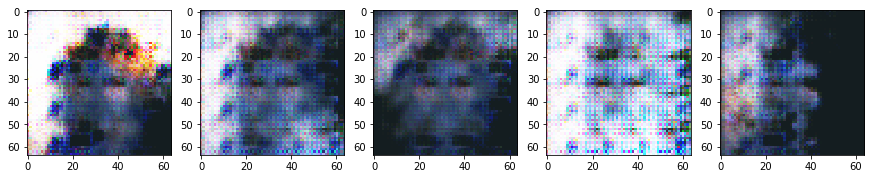

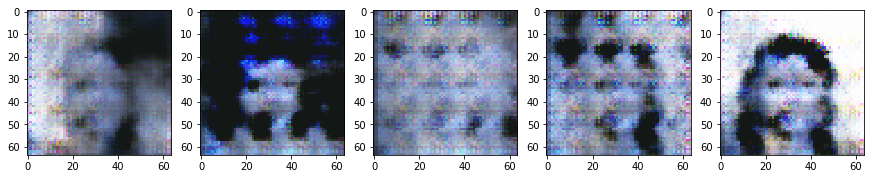

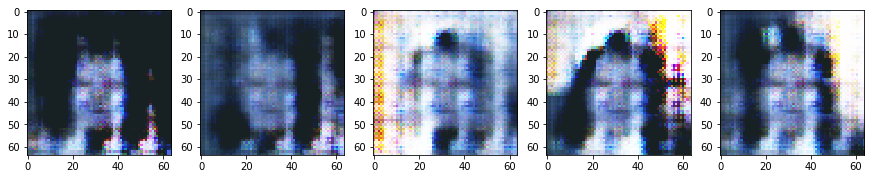

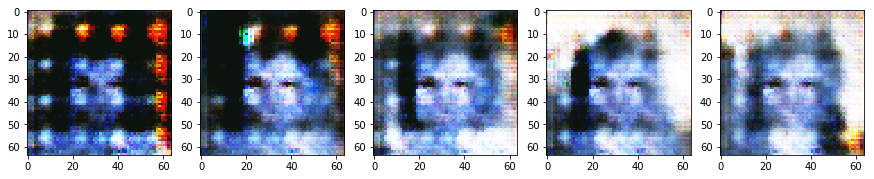

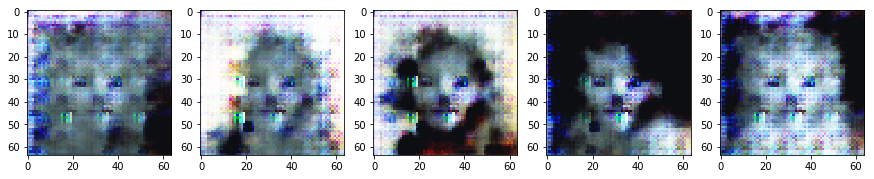

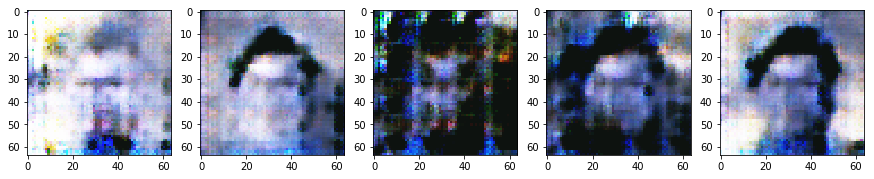

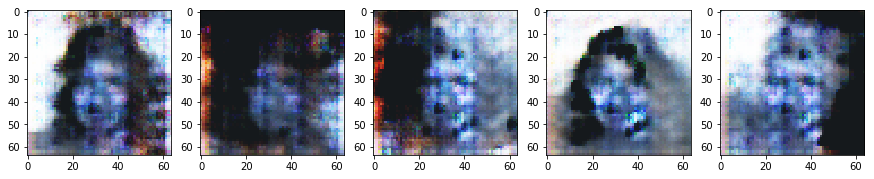

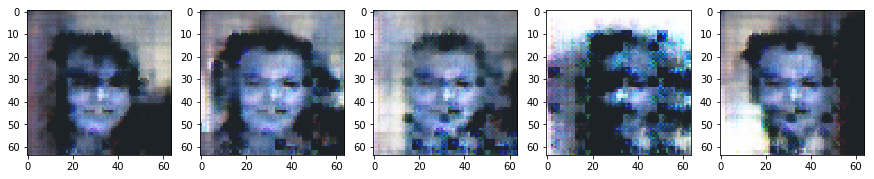

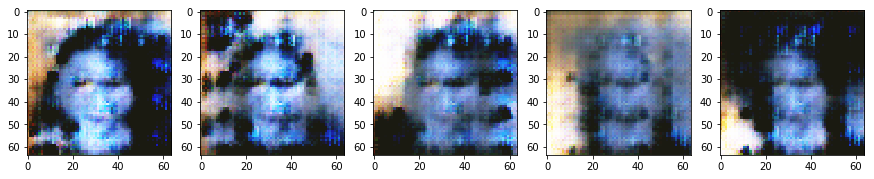

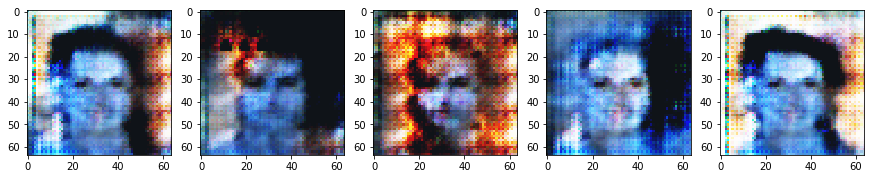

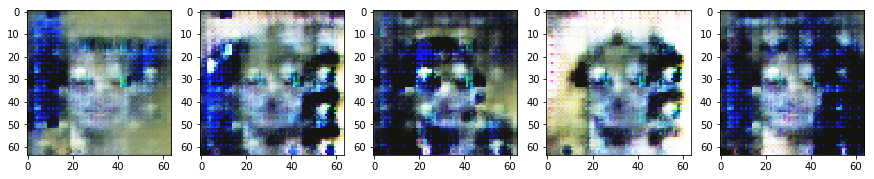

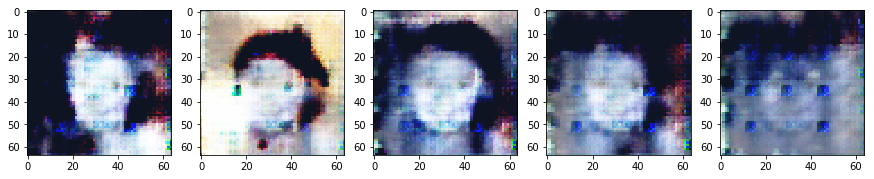

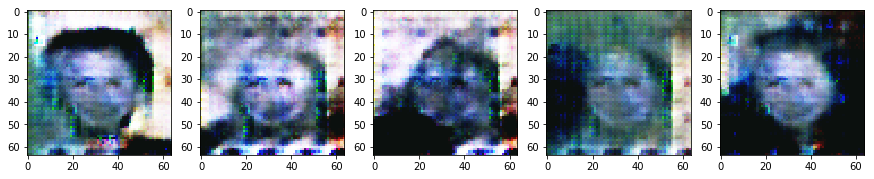

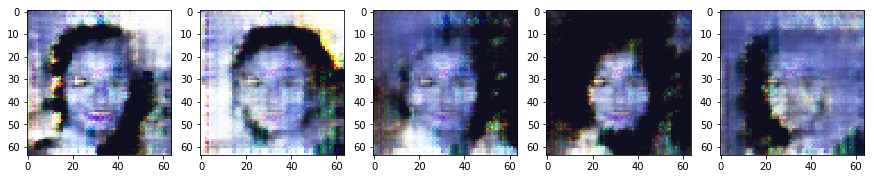

In [11]:
import time
model_save_path = './gan_model.ckpt'

saver = tf.train.Saver()
with tf.Session() as sess:
    print("start")
#     sess.run(tf.global_variables_initializer())
    saver.restore(sess, model_save_path)

    step = 0
    for i in range(1):
        print("start ", i)
        for j in range(num_batch):
            t0 = time.time()
            batch_noise = np.random.uniform(-1.0, 1.0, size=[batch_size, z_dim]).astype(np.float32)
            image_batch = get_next_batch(j)
            
            d_loss_, _ = sess.run([d_loss, d_optim], feed_dict={z: batch_noise, Images:image_batch, is_training: True})
            g_loss_, _ = sess.run([g_loss, g_optim], feed_dict={z: batch_noise, Images:image_batch, is_training: True})
            g_loss_, _ = sess.run([g_loss, g_optim], feed_dict={z: batch_noise, Images:image_batch, is_training: True})
 

            print(step, d_loss_, g_loss_, time.time()-t0)
 
            if step % 100 == 0:
                
                test_noise = np.random.uniform(-1.0, 1.0, size=(5, z_dim)).astype(np.float32)
                fig = plt.figure(figsize=(15,5))
                
                images = sess.run(G, feed_dict={z: test_noise, is_training: False})
                for k in range(5):
                    image = images[k, :, :, :]
                    image += 1
                    image *= 127.5
                    image = np.clip(image, 0, 255).astype(np.uint8)
                    image = np.reshape(image, (IMAGE_SIZE, IMAGE_SIZE, -1))
                    ax =fig.add_subplot(1,5,k+1)
                    ax.imshow(image)
                    
                save_path = saver.save(sess, save_path= model_save_path)
                print("Model saved in file: %s" % save_path)
                
                learning_rate = learning_rate * lr_decay
                
            
            
            step += 1
            
            if step>2000:
                break



reference http://bamos.github.io/2016/08/09/deep-completion/